# Kaggle Competitition Playground Series S3E19. 
 * For this challenge, you will be predicting a full year worth of sales for various fictitious learning modules from different fictitious Kaggle-branded stores in different (real!) countries. This dataset is completely synthetic, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. You are given the task of predicting sales during for year 2022.
 * [Kaggle data set](https://www.kaggle.com/competitions/playground-series-s3e19/data)



In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import os
from pathlib import Path


In [7]:
pwd = os.getcwd()

In [8]:
# Load the datasets
df_train = pd.read_csv('/Users/johnkim/Projects/Kaggle/playground-series/playground-series-s3e19/train.csv')
df_test = pd.read_csv('/Users/johnkim/Projects/Kaggle/playground-series/playground-series-s3e19/test.csv')

In [9]:
df_train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [10]:
df_test.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


# Exploring Data Set

In [11]:
df_train.shape, df_test.shape

((136950, 6), (27375, 5))

In [12]:
# Overview of the training data
overview = pd.DataFrame()

overview['Columns'] = df_train.columns     # Columns
overview['Data Types'] = df_train.dtypes.values     # Data Types
overview['Missing Values'] = df_train.isnull().sum().values     # Nulls 
overview['Unique Values'] = df_train.nunique().values       # Unique values - 5 countries, 3 stores, 5 products, 1826 dates (for 5 years worth of data this indiciative that there are no gaps in days in the data set), id is unique for each record

# We have 5 years worth of training data to predict 2022 sales, with no missing values. Looking good!
overview['Min Date'] = min(df_train['date'])
overview['Max Date'] = max(df_train['date'])

overview

,Columns,Data Types,Missing Values,Unique Values,Min Date,Max Date
0,id,int64,0,136950,2017-01-01,2021-12-31
1,date,object,0,1826,2017-01-01,2021-12-31
2,country,object,0,5,2017-01-01,2021-12-31
3,store,object,0,3,2017-01-01,2021-12-31
4,product,object,0,5,2017-01-01,2021-12-31
5,num_sold,int64,0,1028,2017-01-01,2021-12-31


In [15]:
# Convert date columns to a datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

print(f"Data Type for df_train: {df_train['date'].dtype}")
print(f"Data Type for df_test:  {df_test['date'].dtype}")

Data Type for df_train: datetime64[ns]
Data Type for df_test:  datetime64[ns]


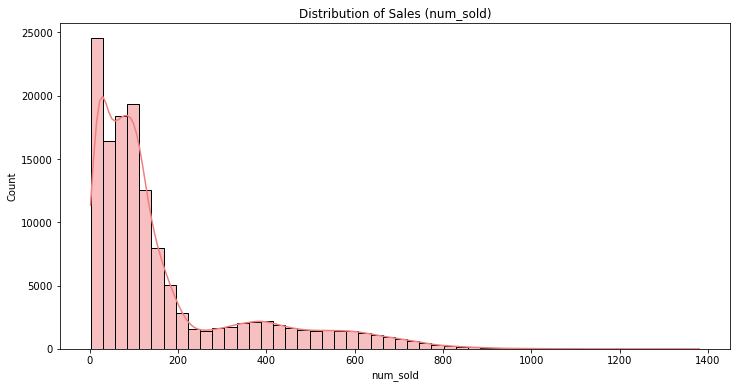

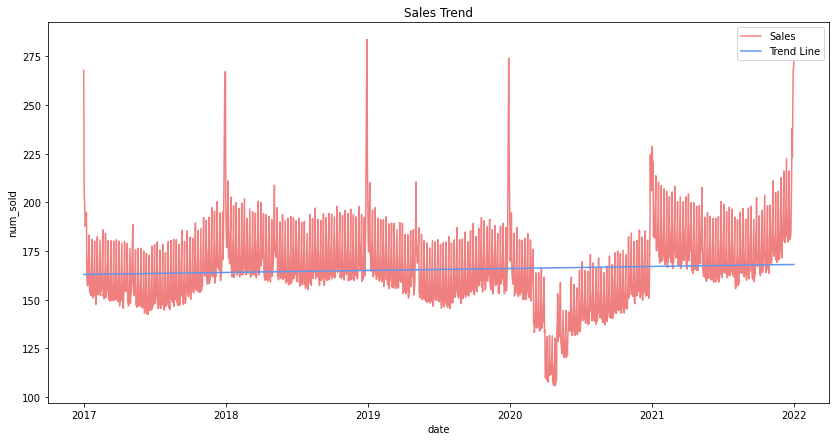

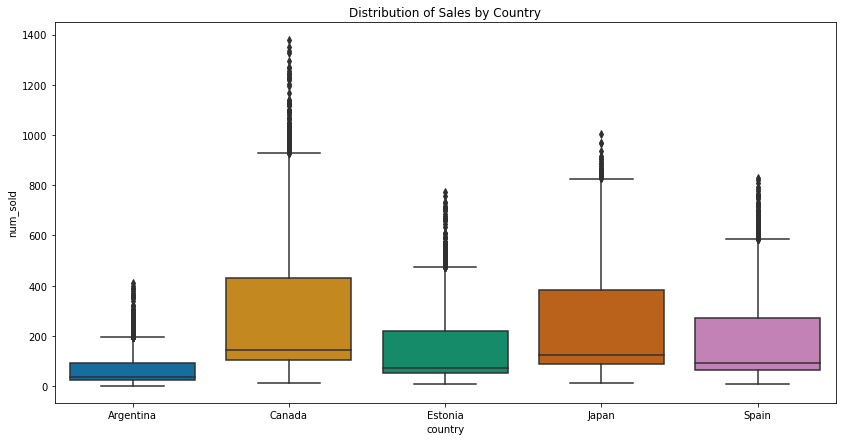

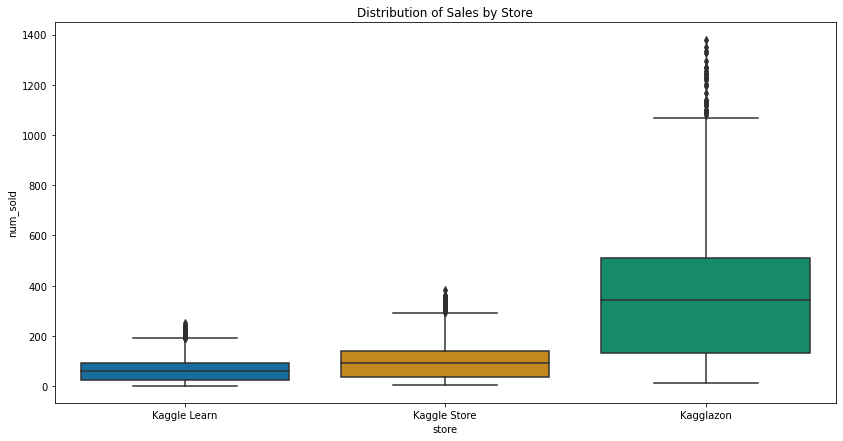

In [36]:
# Sales distribution
plt.figure(figsize=(12, 6))
sb.histplot(df_train['num_sold'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Sales (num_sold)')
plt.show()

# Sales trend over time
plt.figure(figsize=(14, 7))
sb.lineplot(data=df_train, x='date', y='num_sold', ci=None, color='lightcoral', label = 'Sales')

# Calculate the coefficients of a linear regression using numpy
x_values = np.arange(len(df_train['date']))  # Using date index as x values
coefficients = np.polyfit(x_values, df_train['num_sold'], 1) # np.polyfit --- Fits a polynomial p(x) = p[0] * x**deg + ... + p[deg] of degree deg to points (x, y). 1 for Linear Regression.
trend_line = np.polyval(coefficients, x_values)
plt.plot(df_train['date'], trend_line, color='cornflowerblue', label='Trend Line')

plt.title('Sales Trend')
plt.legend()
plt.show()


# Sales by country
plt.figure(figsize=(14, 7))
sb.boxplot(data=df_train, x='country', y='num_sold', palette='colorblind')
plt.title('Distribution of Sales by Country')
plt.show()


# Sales by store
plt.figure(figsize=(14, 7))
sb.boxplot(data=df_train, x='store', y='num_sold', palette='colorblind')
plt.title('Distribution of Sales by Store')
plt.show()

In [37]:
# Extract year, month, and day of the week
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day_of_week'] = df_train['date'].dt.dayofweek  # Monday=0, Sunday=6

df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day_of_week'] = df_test['date'].dt.dayofweek

# Re-arranging columns

desired_order = ['id', 'date', 'year', 'month', 'day_of_week', 'country', 'store', 'product', 'num_sold']
df_train = df_train[desired_order]

# Drop the 'date' column as we have extracted necessary features from it
df_train = df_train.drop(columns=['date'])
df_test = df_test.drop(columns=['date'])
df_train.head()

,id,year,month,day_of_week,country,store,product,num_sold
0,0,2017,1,6,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017,1,6,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017,1,6,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017,1,6,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017,1,6,Argentina,Kaggle Learn,Using LLMs to Write Better,49


## Preprocessing step to categorize features into their own columns and ensure training and test dataframes have identical schemas

In [38]:
# One-hot encoding the categorical features in both training and test datasets
train_encoded = pd.get_dummies(df_train, columns=['country', 'store', 'product'], drop_first=True)
test_encoded = pd.get_dummies(df_test, columns=['country', 'store', 'product'], drop_first=True)

# Ensure the train and test data have the same columns
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
print(missing_cols)
# Adds missing columns to the test df if needed and fills with 0 -- important preprocessing step to ensure consistency when making predictions once we start modeling
for column in missing_cols:
    test_encoded[column] = 0

# Ensure columns are reordered for both dataframes to match
test_encoded = test_encoded[train_encoded.columns]

train_encoded.head()


{'num_sold'}


,id,year,month,day_of_week,num_sold,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,0,2017,1,6,63,0,0,0,0,1,0,0,0,0,0
1,1,2017,1,6,66,0,0,0,0,1,0,1,0,0,0
2,2,2017,1,6,9,0,0,0,0,1,0,0,1,0,0
3,3,2017,1,6,59,0,0,0,0,1,0,0,0,1,0
4,4,2017,1,6,49,0,0,0,0,1,0,0,0,0,1


In [39]:
test_encoded.head()

,id,year,month,day_of_week,num_sold,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,136950,2022,1,5,0,0,0,0,0,1,0,0,0,0,0
1,136951,2022,1,5,0,0,0,0,0,1,0,1,0,0,0
2,136952,2022,1,5,0,0,0,0,0,1,0,0,1,0,0
3,136953,2022,1,5,0,0,0,0,0,1,0,0,0,1,0
4,136954,2022,1,5,0,0,0,0,0,1,0,0,0,0,1


In [40]:
# Quick sanity check on column numbers matching
train_encoded.shape, test_encoded.shape


((136950, 15), (27375, 15))

In [41]:
# Separate features and target variable from training dataset
X = train_encoded.drop(columns=['id', 'num_sold'])
y = train_encoded['num_sold']

# Splitting the data into training and validation sets (80% data set used for training, 20% data set used for validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33)

X_train.shape, X_val.shape


# X_train: The features for training.
# y_train: The corresponding target values for training.
# X_val: The features for validation.
# y_val: The corresponding target values for validation.

((109560, 13), (27390, 13))

In [ ]:
# Check data types are compatible before modeling
X_train.dtypes


year                                                      int64
month                                                     int64
day_of_week                                               int64
country_Canada                                            uint8
country_Estonia                                           uint8
country_Japan                                             uint8
country_Spain                                             uint8
store_Kaggle Learn                                        uint8
store_Kaggle Store                                        uint8
product_Using LLMs to Train More LLMs                     uint8
product_Using LLMs to Win Friends and Influence People    uint8
product_Using LLMs to Win More Kaggle Competitions        uint8
product_Using LLMs to Write Better                        uint8
dtype: object

In [45]:
# Check data types are compatible before modeling
y_train.dtypes

dtype('int64')

## Evaluating modeling options

In [46]:
# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=33),
    "Gradient Boosting": GradientBoostingRegressor(random_state=33),
    "XGBoost": XGBRegressor(random_state=33)
}

# Train and evaluate each model
rmse_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train) # training features vs. target values for training
    y_pred = model.predict(X_val) # predicting target values as a function of features for validation
    rmse_scores[name] = np.sqrt(mean_squared_error(y_val, y_pred)) # evaluating root mean squared error for each model between predicted values vs. target values for validation

rmse_scores

{'Linear Regression': 91.97629168423543,
 'Random Forest': 23.88201337233974,
 'Gradient Boosting': 53.574663340434306,
 'XGBoost': 21.601556145802824}

## <span style="color:cornflowerblue">XGBoost produces most accurate prediction for 2022 sales!</span>


In [53]:
# Define hyperparameters and their possible values
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'tree_method': ['auto']  
}

# Initialize GridSearchCV -- The goal is to find the best combination of hyperparameters for an XGBoost regression model.
xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=33, tree_method='auto'),  # Specify to use GPU (gpu_hist) or CPU for histogram-based tree methods. GPU is faster but not compatible on M1 Mac?
    param_grid,
    cv=3, # 3-fold cross-validation. Partition data set into 3 parts and train/evaluate 3 times, each time using a different subset for validation.
    scoring='neg_mean_squared_error', # Indicates that the evaluation metric for comparing different hyperparameter combinations is the negative mean squared error (MSE). The negative value is used because GridSearchCV tries to maximize the scoring metric, so by using the negative MSE, it effectively minimizes the actual MSE.
    verbose=2, # This controls the verbosity of the output during the tuning process. A higher value (e.g., 2) will provide more detailed progress information.
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
xgb_grid.fit(X_train, y_train)  #  Fitting the XGBoost regression model using the training data by going through different combinations of hyperparameters from the defined parameter grid and train the XGBoost model using each combination.

# Get the best parameters and best RMSE
best_params = xgb_grid.best_params_ # best parameters for performance and minimizing MSE
best_rmse = np.sqrt(-xgb_grid.best_score_)  # The -xgb_grid.best_score_ value represents the negative of the best mean squared error achieved during the cross-validation. Taking the square root of this negative value gives the RMSE.

print(f"Best training parameters for GridSearchCV and RMSE: {best_params}, {best_rmse}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9, tree_method=auto; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8, tree_method=auto; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8, tree_method=auto; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1, tree_method=auto; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8, tree_method=auto; total time=   1.9s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1, tree_method=auto; total time=   1.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.9, tree_method=auto; total time=   1.9s
[CV] END c

({'colsample_bytree': 1,
  'learning_rate': 0.1,
  'max_depth': 7,
  'n_estimators': 150,
  'subsample': 0.8,
  'tree_method': 'auto'},
 20.95585381694599)

In [2]:
# Model Evaluation
best_model = xgb_grid.best_estimator_
y_pred_val = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Best Validation RMSE with best XGBoost parameters: {rmse_val}")

NameError: name 'xgb_grid' is not defined

In [58]:
# Best hyperparameters from the grid search
best_hyperparameters = {
    'colsample_bytree': 1,
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 150,
    'subsample': 0.8,
    'tree_method': 'auto',
    'random_state': 33
}

# 1. Model Evaluation
best_xgb_model = XGBRegressor(**best_hyperparameters)
best_xgb_model.fit(X_train, y_train)
y_pred_val = best_xgb_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

# 2. Model Interpretation (Feature Importance)
importance = best_xgb_model.feature_importances_
feature_importance_series = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

# 3. Model Training on Full Data
best_xgb_model.fit(X, y)  # X and y are the full training data

# Preprocess the test dataset
test_encoded = pd.get_dummies(df_test, columns=['country', 'store', 'product'], drop_first=True)
missing_cols = set(X_train.columns) - set(test_encoded.columns)
for c in missing_cols:
    test_encoded[c] = 0
X_test_encoded = test_encoded[X_train.columns]

# 4. Predictions on Test Data
test_predictions = best_xgb_model.predict(X_test_encoded)

# 5. Submission
final_df = df_test[['id']].copy()  # select id from test df and copy into new df
final_df['num_sold'] = test_predictions # predicted sales from XGBoost best model

rmse_val, feature_importance_series.head()  # Displaying RMSE and top feature importances

(21.423390101491904,
 store_Kaggle Store                                        0.292379
 product_Using LLMs to Win Friends and Influence People    0.243516
 country_Canada                                            0.125344
 store_Kaggle Learn                                        0.117559
 country_Japan                                             0.104780
 dtype: float32)

In [61]:
# Save the submission dataframe to a CSV file
filepath = Path(pwd + '/submission.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
final_df.to_csv('submission.csv', index=False)

#final_df.to_csv('pwd+ '/submission.csv', index=False)

